# __Treino e testes da rede neural__
- Dataset: Guarujá (cap. 3)

##### Copyright 2021 Caio Azevedo - ensaios de uma dissertação. 

13 de junho de 2021 - última atualização __todo santo dia__
- ref. https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref. https://www.tensorflow.org/tutorials/structured_data/feature_columns

__Objetivos__:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.

__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV


Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

Sobre as métricas
- ref. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
#gráfico que relacionada cada uma das features com o valor predito
def plotSwarmChart(dataSet):
    dataSet['Constante'] = 0 #feature inútil para referência do gráfico

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constante'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [5]:
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [6]:
#https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('Área curva ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='aleatório', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RNA', color='blue')
    
    # axis labels
    pyplot.xlabel('Taxa de falso positivo')
    pyplot.ylabel('Taxa de verdadeiro positivo')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [7]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
APP_PATH = os.getcwd()

#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
#file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_nocorrencias_1km_shuffled.csv"
#file = "pt_nocorrencias_2km_shuffled.csv"
#file = "pt_nocorrencias_3km_shuffled.csv"
#file = "pt_nocorrencias_4km_shuffled.csv"

file = "ptos_aleatorios_shuffled.csv"


dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 
#dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", "ptos_aleatorios.csv")))

# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
#dataset.to_csv(os.path.join(APP_PATH, os.path.join("data", "ptos_aleatorios_shuffled.csv")))
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,TWI,Curvatura,Declividade,Elevacao,Aspecto,Geologia,Uso,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [8]:
#dataset["eng_1"] = dataset["Elevacao"] / dataset["Declividade"]

In [9]:
dataset.rename(columns={'TWI': 'twi','Curvatura': 'curv', 'Declividade': 'slope','Elevacao': 'elevation','Aspecto': 'aspect', 'Geologia': 'lito', 'Uso': 'uso_solo'}, inplace=True)
dataset = dataset[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
#dataset = dataset[['aspect','uso_solo','lito','twi','curv','class','eng_1']]
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [10]:
dataset.shape

(200, 8)

In [11]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,23.94,209.79,64.32,75.80,32.56,14.42,0.03,0.5
std,11.79,103.92,56.08,26.72,31.56,13.62,0.41,0.5
min,0.09,0.04,0.23,20.00,2.00,0.09,-0.59,0.0
25%,18.08,121.04,14.33,90.00,2.00,4.29,-0.01,0.0
50%,25.33,202.74,54.48,90.00,2.00,6.13,-0.00,0.0
75%,30.77,316.40,94.71,90.00,65.00,26.33,0.00,1.0
max,69.73,359.51,226.06,90.00,65.00,69.73,4.30,1.0


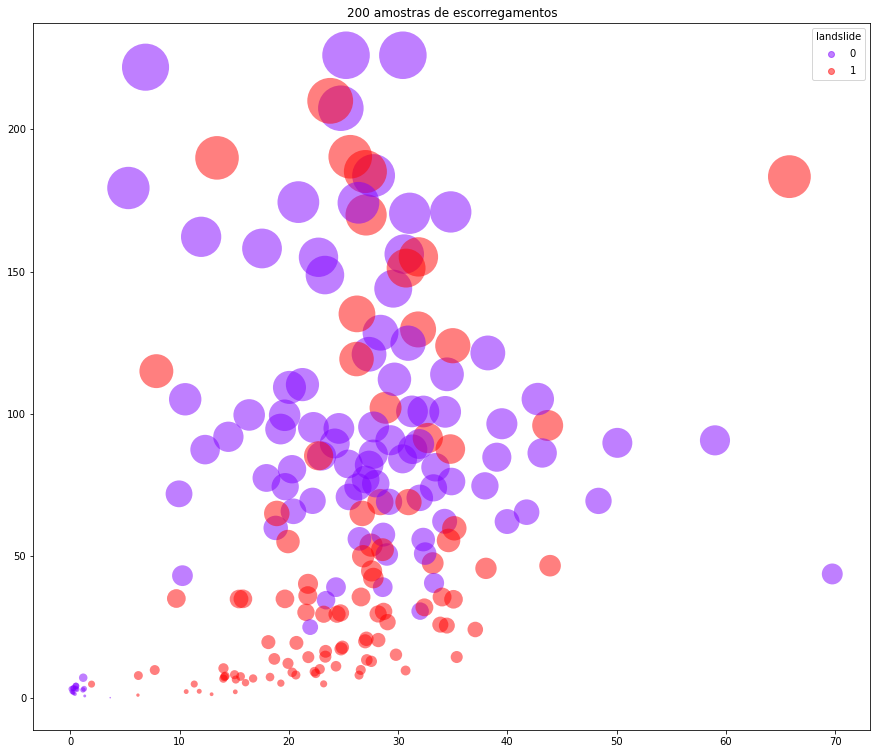

In [12]:
fig, ax = plt.subplots(figsize=(15,13))
sizes = dataset['elevation']*10
scatter = ax.scatter(dataset['slope'], dataset['elevation'], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

ax.title.set_text("{}{}".format(len(dataset.index), ' amostras de escorregamentos')) 

plt.show()

## Preparação dos dados (Remoção das features irrelevantes & Normalização)
__Cuidado com data leakage, considerar as melhores práticas:__
- Train-Test Evaluation With Correct Data Preparation
- ref. https://realpython.com/train-test-split-python-data/
- Data Preparation With k-fold Cross-Validation

- ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref. https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref. https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref. https://www.section.io/engineering-education/data-leakage/
- ref. https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1

 __Segue abaixo, a ordem de relevância das variáveis, bem como a identificação daquelas que podem ser removidas (vide analise análise da features).__
  - elevation | elevation (ok) 
  - uso_solo | uso_solo (ok)
  - twi | curvatura (ok)
  - curvatura | twi (ok)
  - lito | aspect   __(to be tested)__
  - aspect | lito   __(to be tested)__
  - slope | slope   __(to be tested)__

In [13]:
#features menos relevantes guaruja
#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('curv',axis=1)
#dataset = dataset.drop('lito',axis=1)
#dataset = dataset.drop('uso_solo',axis=1)

# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [14]:
#divide o dataset em base de treino e teste
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(X_train)
    # scale the training dataset
    X_train = scaler.transform(X_train)
    
    # scale the test dataset
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [15]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [16]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation2(dataset)
#X_train, X_test, y_train, y_test = dataPreparation(dataset)

In [17]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [18]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [19]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [20]:
X.shape

(200, 7)

In [21]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [22]:
y.shape

(200, 1)

In [23]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


In [24]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

__Computa o número de variáveis de entrada (features) e saída (sempre 1)__

In [25]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

## Rede Neural Customizada
### Força Bruta para tuning dos hiperparametros 
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

In [26]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [27]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [28]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #camada de entrada
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

#regularizacao por dropout e com inicialização de pesos e bias
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,dropout_prob = droput,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

#regularizacao por L2 e sem inicialização de pesos e bias
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,reg_func=l2_regularization,reg_strength=1e-2,activation=rna.relu))
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,dropout_prob = droput,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))        
    #camada de saída
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [29]:
#def setBestNeuralNetwork2(num_learning_rate,input_dim, output_dim):
#    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, patience=10) 

    #camada de entrada 
#    nn.layers.append(Layer(input_dim=input_dim, output_dim=20,activation= rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

#    nn.layers.append(Layer(input_dim=20, output_dim=10,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
    #nn.layers.append(Layer(input_dim=10, output_dim=10,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
 
    #camadad de saída
#    nn.layers.append(Layer(input_dim=10, output_dim=output_dim,activation=rna.sigmoid))  

#    return nn

In [30]:
#def setBestNeuralNetwork3(num_learning_rate,input_dim, output_dim):
#    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate,momentum=0.25, patience=10) 

    #camada de entrada - considerar tanh na segunda camada e com dropout 0.2821478566400208
#    nn.layers.append(Layer(input_dim=input_dim, output_dim=7,activation= rna.relu, weights_initializer=rna.glorot_normal))

#    nn.layers.append(Layer(input_dim=7, output_dim=20 ,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
    #nn.layers.append(Layer(input_dim=7, output_dim=14,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
#    nn.layers.append(Layer(input_dim=20, output_dim=7,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
 
    #camada de saída
#    nn.layers.append(Layer(input_dim=7, output_dim=output_dim,activation=rna.sigmoid, weights_initializer=rna.glorot_normal))  

#    return nn

In [31]:
# (batch_size) implementa o mini-batch que acelera o tempo de treinamento, requer método de inicialização do mini-batch. 
#ideal que o batch_size seja multiplo do tamanho do conjunto de dados de treinamento, que aqui é de 128 

neurons = [7,8,12] 
# preciso encontrar uma forma de implementar a alteração do numero de neuronios na camada oculta variando 
# de n-2 até n+6
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [32]:
def setTestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Camada de Entrada: {} neurônios inputs  {} neurônios saída {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' _camada oculta {} neurônios {} camadas '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} neurônios da ultima camada oculta, {} neurônios na de saída \033[0m'.format(neurons,output_dim))

In [33]:
tot = 1
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    setTestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    tot += tot
                    #print('Para {} neurônios, {} camadas,  {} learning rate, {} batch size, {} dropout rate, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

print(tot)

 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 

In [34]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('Para {} neurônios, {} camadas,  {} learning rate, {} batch size, {} dropout rate, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 0.84490023 + 0.00000000 = 0.84490023 loss_val = 0.84490023
epoch: 3000/40000 loss_train: 0.61791103 + 0.00000000 = 0.61791103 loss_val = 0.61791103
epoch: 6000/40000 loss_train: 0.49647476 + 0.00000000 = 0.49647476 loss_val = 0.49647476
epoch: 9000/40000 loss_train: 0.38543520 + 0.00000000 = 0.38543520 loss_val = 0.38543520
epoch: 12000/40000 loss_train: 0.29875299 + 0.00000000 = 0.29875299 loss_val = 0.29875299
epoch: 15000/40000 loss_train: 0.23619341 + 0.00000000 = 0.23619341 loss_val = 0.23619341
epoch: 18000/40000 loss_train: 0.18882290 + 0.00000000 = 0.18882290 loss_val = 0.18882290
epoch: 21000/40000 loss_train: 0.15404901 + 0.00000000 = 0.15404901 loss_val = 0.15404901
epoch: 24000/40000 loss_train: 0.12861807 + 0.00000000 = 0.12861807 loss_val = 0.12861807
epoch: 27000/40000 loss_train: 0.10554305 + 0.00000000 = 0.10554305 loss_val = 0.10554305
epoch: 30000/40000 loss_train: 0.09085746 + 0.00000000 = 0.09085746 loss_val = 0.09085746
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.17592744 + 0.00000000 = 0.17592744 loss_val = 0.17592744
epoch: 6000/40000 loss_train: 0.09042227 + 0.00000000 = 0.09042227 loss_val = 0.09042227
epoch: 9000/40000 loss_train: 0.07387703 + 0.00000000 = 0.07387703 loss_val = 0.07387703
epoch: 12000/40000 loss_train: 0.06518340 + 0.00000000 = 0.06518340 loss_val = 0.06518340
epoch: 15000/40000 loss_train: 0.05976690 + 0.00000000 = 0.05976690 loss_val = 0.05976690
epoch: 18000/40000 loss_train: 0.05624571 + 0.00000000 = 0.05624571 loss_val = 0.05624571
epoch: 21000/40000 loss_train: 0.05325584 + 0.00000000 = 0.05325584 loss_val = 0.05325584
epoch: 24000/40000 loss_train: 0.04945497 + 0.00000000 = 0.04945497 loss_val = 0.04945497
epoch: 27000/40000 loss_train: 0.04650064 + 0.00000000 = 0.04650064 loss_val = 0.04650064
epoch: 30000/40000 loss_train: 0.04388610 + 0.00000000 = 0.04388610 loss_val = 0.04388610
epoch: 33000/40000 loss_train: 0.04090960 + 0.00000000 = 0.04090960 loss_val = 0.04090960
epoch: 36000/

Para 7 neurônios, 1 camadas,  0.01 learning rate, 0 batch size, 0.1 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.88019539 + 0.00000000 = 0.88019539 loss_val = 0.88019539
epoch: 3000/40000 loss_train: 0.06880689 + 0.00000000 = 0.06880689 loss_val = 0.06880689
epoch: 6000/40000 loss_train: 0.03859362 + 0.00000000 = 0.03859362 loss_val = 0.03859362
epoch: 9000/40000 loss_train: 0.02500158 + 0.00000000 = 0.02500158 loss_val = 0.02500158
epoch: 12000/40000 loss_train: 0.01678448 + 0.00000000 = 0.01678448 loss_val = 0.01678448
epoch: 15000/40000 loss_train: 0.01178272 + 0.00000000 = 0.01178272 loss_val = 0.01178272
epoch: 18000/40000 loss_train: 0.00868066 + 0.00000000 = 0.00868066 loss_val = 0.00868066
epoch: 21000/40000 loss_train: 0.00666388 + 0.00000000 = 0.00666388 loss_val = 0.00666388
epoch: 24000/40000 loss_train: 0.00529181 + 0.00000000 = 0.00529181 loss_val = 0.00529181
epoch: 27000/40000 loss_train: 0.00431985 + 0.00000000 = 0.00431985 loss_val = 0.0043

epoch: 27000/40000 loss_train: 0.07941812 + 0.00000000 = 0.07941812 loss_val = 0.07941812
epoch: 30000/40000 loss_train: 0.07189178 + 0.00000000 = 0.07189178 loss_val = 0.07189178
epoch: 33000/40000 loss_train: 0.06623296 + 0.00000000 = 0.06623296 loss_val = 0.06623296
epoch: 36000/40000 loss_train: 0.06099610 + 0.00000000 = 0.06099610 loss_val = 0.06099610
epoch: 39000/40000 loss_train: 0.05650743 + 0.00000000 = 0.05650743 loss_val = 0.05650743
Para 8 neurônios, 1 camadas,  0.001 learning rate, 4 batch size, 0.1 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 1.68995977 + 0.00000000 = 1.68995977 loss_val = 1.68995977
epoch: 3000/40000 loss_train: 0.67155373 + 0.00000000 = 0.67155373 loss_val = 0.67155373
epoch: 6000/40000 loss_train: 0.60119635 + 0.00000000 = 0.60119635 loss_val = 0.60119635
epoch: 9000/40000 loss_train: 0.47645523 + 0.00000000 = 0.47645523 loss_val = 0.47645523
epoch: 12000/40000 loss_train: 0.33178965 + 0.00000000 = 0.33178965 loss_val = 0.3317

epoch: 9000/40000 loss_train: 0.03696388 + 0.00000000 = 0.03696388 loss_val = 0.03696388
epoch: 12000/40000 loss_train: 0.02574510 + 0.00000000 = 0.02574510 loss_val = 0.02574510
epoch: 15000/40000 loss_train: 0.01966042 + 0.00000000 = 0.01966042 loss_val = 0.01966042
epoch: 18000/40000 loss_train: 0.01575344 + 0.00000000 = 0.01575344 loss_val = 0.01575344
epoch: 21000/40000 loss_train: 0.01300234 + 0.00000000 = 0.01300234 loss_val = 0.01300234
epoch: 24000/40000 loss_train: 0.01096001 + 0.00000000 = 0.01096001 loss_val = 0.01096001
epoch: 27000/40000 loss_train: 0.00939232 + 0.00000000 = 0.00939232 loss_val = 0.00939232
epoch: 30000/40000 loss_train: 0.00817141 + 0.00000000 = 0.00817141 loss_val = 0.00817141
epoch: 33000/40000 loss_train: 0.00718140 + 0.00000000 = 0.00718140 loss_val = 0.00718140
epoch: 36000/40000 loss_train: 0.00636707 + 0.00000000 = 0.00636707 loss_val = 0.00636707
epoch: 39000/40000 loss_train: 0.00568831 + 0.00000000 = 0.00568831 loss_val = 0.00568831
Para 8 neur

epoch: 30000/40000 loss_train: 0.08206011 + 0.00000000 = 0.08206011 loss_val = 0.08206011
epoch: 33000/40000 loss_train: 0.07984468 + 0.00000000 = 0.07984468 loss_val = 0.07984468
epoch: 36000/40000 loss_train: 0.07792791 + 0.00000000 = 0.07792791 loss_val = 0.07792791
epoch: 39000/40000 loss_train: 0.07622701 + 0.00000000 = 0.07622701 loss_val = 0.07622701
Para 12 neurônios, 1 camadas,  0.001 learning rate, 0 batch size, 0 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 1.41084577 + 0.00000000 = 1.41084577 loss_val = 1.41084577
epoch: 3000/40000 loss_train: 0.35936070 + 0.00000000 = 0.35936070 loss_val = 0.35936070
epoch: 6000/40000 loss_train: 0.20867458 + 0.00000000 = 0.20867458 loss_val = 0.20867458
epoch: 9000/40000 loss_train: 0.14220915 + 0.00000000 = 0.14220915 loss_val = 0.14220915
epoch: 12000/40000 loss_train: 0.11183756 + 0.00000000 = 0.11183756 loss_val = 0.11183756
epoch: 15000/40000 loss_train: 0.09547652 + 0.00000000 = 0.09547652 loss_val = 0.0954

epoch: 33000/40000 loss_train: 0.01748907 + 0.00000000 = 0.01748907 loss_val = 0.01748907
epoch: 36000/40000 loss_train: 0.01530165 + 0.00000000 = 0.01530165 loss_val = 0.01530165
epoch: 39000/40000 loss_train: 0.01339745 + 0.00000000 = 0.01339745 loss_val = 0.01339745
Para 12 neurônios, 1 camadas,  0.005 learning rate, 0 batch size, 0 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 0.73666182 + 0.00000000 = 0.73666182 loss_val = 0.73666182
epoch: 3000/40000 loss_train: 0.09518169 + 0.00000000 = 0.09518169 loss_val = 0.09518169
epoch: 6000/40000 loss_train: 0.04612953 + 0.00000000 = 0.04612953 loss_val = 0.04612953
epoch: 9000/40000 loss_train: 0.03273094 + 0.00000000 = 0.03273094 loss_val = 0.03273094
epoch: 12000/40000 loss_train: 0.02559557 + 0.00000000 = 0.02559557 loss_val = 0.02559557
epoch: 15000/40000 loss_train: 0.02077753 + 0.00000000 = 0.02077753 loss_val = 0.02077753
epoch: 18000/40000 loss_train: 0.01737168 + 0.00000000 = 0.01737168 loss_val = 0.01737

epoch: 39000/40000 loss_train: 0.00206632 + 0.00000000 = 0.00206632 loss_val = 0.00206632
Para 12 neurônios, 1 camadas,  0.01 learning rate, 4 batch size, 0 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.71990213 + 0.00000000 = 0.71990213 loss_val = 0.71990213
epoch: 3000/40000 loss_train: 0.06283559 + 0.00000000 = 0.06283559 loss_val = 0.06283559
epoch: 6000/40000 loss_train: 0.03716407 + 0.00000000 = 0.03716407 loss_val = 0.03716407
epoch: 9000/40000 loss_train: 0.02609718 + 0.00000000 = 0.02609718 loss_val = 0.02609718
epoch: 12000/40000 loss_train: 0.01928906 + 0.00000000 = 0.01928906 loss_val = 0.01928906
epoch: 15000/40000 loss_train: 0.01434287 + 0.00000000 = 0.01434287 loss_val = 0.01434287
epoch: 18000/40000 loss_train: 0.01083743 + 0.00000000 = 0.01083743 loss_val = 0.01083743
epoch: 21000/40000 loss_train: 0.00839689 + 0.00000000 = 0.00839689 loss_val = 0.00839689
epoch: 24000/40000 loss_train: 0.00660391 + 0.00000000 = 0.00660391 loss_val = 0.00660

epoch: 6000/40000 loss_train: 0.64807544 + 0.00000000 = 0.64807544 loss_val = 0.64807544
epoch: 9000/40000 loss_train: 0.59744734 + 0.00000000 = 0.59744734 loss_val = 0.59744734
epoch: 12000/40000 loss_train: 0.48980427 + 0.00000000 = 0.48980427 loss_val = 0.48980427
epoch: 15000/40000 loss_train: 0.35194604 + 0.00000000 = 0.35194604 loss_val = 0.35194604
epoch: 18000/40000 loss_train: 0.24543329 + 0.00000000 = 0.24543329 loss_val = 0.24543329
epoch: 21000/40000 loss_train: 0.18753172 + 0.00000000 = 0.18753172 loss_val = 0.18753172
epoch: 24000/40000 loss_train: 0.15469939 + 0.00000000 = 0.15469939 loss_val = 0.15469939
epoch: 27000/40000 loss_train: 0.13316036 + 0.00000000 = 0.13316036 loss_val = 0.13316036
epoch: 30000/40000 loss_train: 0.11255763 + 0.00000000 = 0.11255763 loss_val = 0.11255763
epoch: 33000/40000 loss_train: 0.09370083 + 0.00000000 = 0.09370083 loss_val = 0.09370083
epoch: 36000/40000 loss_train: 0.08291724 + 0.00000000 = 0.08291724 loss_val = 0.08291724
epoch: 39000

epoch: 6000/40000 loss_train: 0.01118304 + 0.00000000 = 0.01118304 loss_val = 0.01118304
epoch: 9000/40000 loss_train: 0.00536655 + 0.00000000 = 0.00536655 loss_val = 0.00536655
epoch: 12000/40000 loss_train: 0.00308841 + 0.00000000 = 0.00308841 loss_val = 0.00308841
epoch: 15000/40000 loss_train: 0.00202457 + 0.00000000 = 0.00202457 loss_val = 0.00202457
epoch: 18000/40000 loss_train: 0.00144812 + 0.00000000 = 0.00144812 loss_val = 0.00144812
epoch: 21000/40000 loss_train: 0.00110086 + 0.00000000 = 0.00110086 loss_val = 0.00110086
epoch: 24000/40000 loss_train: 0.00087345 + 0.00000000 = 0.00087345 loss_val = 0.00087345
epoch: 27000/40000 loss_train: 0.00071602 + 0.00000000 = 0.00071602 loss_val = 0.00071602
epoch: 30000/40000 loss_train: 0.00060142 + 0.00000000 = 0.00060142 loss_val = 0.00060142
epoch: 33000/40000 loss_train: 0.00051487 + 0.00000000 = 0.00051487 loss_val = 0.00051487
epoch: 36000/40000 loss_train: 0.00044783 + 0.00000000 = 0.00044783 loss_val = 0.00044783
epoch: 39000

epoch: 30000/40000 loss_train: 0.05058964 + 0.00000000 = 0.05058964 loss_val = 0.05058964
epoch: 33000/40000 loss_train: 0.04391130 + 0.00000000 = 0.04391130 loss_val = 0.04391130
epoch: 36000/40000 loss_train: 0.03898935 + 0.00000000 = 0.03898935 loss_val = 0.03898935
epoch: 39000/40000 loss_train: 0.03514223 + 0.00000000 = 0.03514223 loss_val = 0.03514223
Para 8 neurônios, 2 camadas,  0.001 learning rate, 4 batch size, 0 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.71274042 + 0.00000000 = 0.71274042 loss_val = 0.71274042
epoch: 3000/40000 loss_train: 0.58743508 + 0.00000000 = 0.58743508 loss_val = 0.58743508
epoch: 6000/40000 loss_train: 0.48415372 + 0.00000000 = 0.48415372 loss_val = 0.48415372
epoch: 9000/40000 loss_train: 0.32639490 + 0.00000000 = 0.32639490 loss_val = 0.32639490
epoch: 12000/40000 loss_train: 0.20618773 + 0.00000000 = 0.20618773 loss_val = 0.20618773
epoch: 15000/40000 loss_train: 0.15136394 + 0.00000000 = 0.15136394 loss_val = 0.15136

epoch: 12000/40000 loss_train: 0.06327289 + 0.00000000 = 0.06327289 loss_val = 0.06327289
epoch: 15000/40000 loss_train: 0.06061143 + 0.00000000 = 0.06061143 loss_val = 0.06061143
epoch: 18000/40000 loss_train: 0.05885737 + 0.00000000 = 0.05885737 loss_val = 0.05885737
epoch: 21000/40000 loss_train: 0.05749466 + 0.00000000 = 0.05749466 loss_val = 0.05749466
epoch: 24000/40000 loss_train: 0.05625829 + 0.00000000 = 0.05625829 loss_val = 0.05625829
epoch: 27000/40000 loss_train: 0.05506437 + 0.00000000 = 0.05506437 loss_val = 0.05506437
epoch: 30000/40000 loss_train: 0.05389770 + 0.00000000 = 0.05389770 loss_val = 0.05389770
epoch: 33000/40000 loss_train: 0.05275378 + 0.00000000 = 0.05275378 loss_val = 0.05275378
epoch: 36000/40000 loss_train: 0.05164632 + 0.00000000 = 0.05164632 loss_val = 0.05164632
epoch: 39000/40000 loss_train: 0.05059107 + 0.00000000 = 0.05059107 loss_val = 0.05059107
Para 8 neurônios, 2 camadas,  0.005 learning rate, 8 batch size, 0 dropout rate, temos:  Acurácia: 9

epoch: 12000/40000 loss_train: 0.15472527 + 0.00000000 = 0.15472527 loss_val = 0.15472527
epoch: 15000/40000 loss_train: 0.11538995 + 0.00000000 = 0.11538995 loss_val = 0.11538995
epoch: 18000/40000 loss_train: 0.09368492 + 0.00000000 = 0.09368492 loss_val = 0.09368492
epoch: 21000/40000 loss_train: 0.08165441 + 0.00000000 = 0.08165441 loss_val = 0.08165441
Para 12 neurônios, 2 camadas,  0.001 learning rate, 0 batch size, 0.1 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 1.32116694 + 0.00000000 = 1.32116694 loss_val = 1.32116694
epoch: 3000/40000 loss_train: 0.60828856 + 0.00000000 = 0.60828856 loss_val = 0.60828856
epoch: 6000/40000 loss_train: 0.44357293 + 0.00000000 = 0.44357293 loss_val = 0.44357293
epoch: 9000/40000 loss_train: 0.22844776 + 0.00000000 = 0.22844776 loss_val = 0.22844776
epoch: 12000/40000 loss_train: 0.11770244 + 0.00000000 = 0.11770244 loss_val = 0.11770244
epoch: 15000/40000 loss_train: 0.08182295 + 0.00000000 = 0.08182295 loss_val = 0.081

KeyboardInterrupt: 

In [ ]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [ ]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann.acuracia,best_ann.ann))

In [ ]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [ ]:
lst_hyperP = []
lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork2(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=46000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
        #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,10,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [ ]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [ ]:
#best_ann2 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann2.acuracia,best_ann2.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann2.acuracia,best_ann2.ann))

In [ ]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [ ]:
#lst_hyperP = []
#lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork3(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=36000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,20,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [ ]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [ ]:
#best_ann3 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann3.acuracia,best_ann3.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann3.acuracia,best_ann3.ann))

In [ ]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

# Avaliação da rede Proprietária

https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb

In [ ]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% foi a melhor\033[1m acurácia\033[0m, {:.2f} acc média {} RNA!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

In [ ]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [ ]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [ ]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

Segunda abordagem - configura uma nova rede com os parametros obtidos da otimização por força bruta

In [ ]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [ ]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

In [ ]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

In [ ]:
bstANN = bestNN
#bst_hyper = bstANN.hyper
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [ ]:
if accu >= 85:
    print('{:.2f}%, ótima acurácia de teste, rede salva!'.format(accu))
    bestNN.save('bestANN\suscetibilidadeNN_guaruja.pkl')
else:
    print('Acurácia: {:.2f}% acurácia de validação abaixo de .85!'.format(accu))

In [ ]:
y_pred = bestNN.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X_test)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [ ]:
yhat_probs = bestNN.predict(X_train)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_train, yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_train, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_test, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X_val)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_val,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_val, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y, yhat_probs)

In [ ]:
printAUROC(y,yhat_probs)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y,(yhat_probs > 0.5))

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de Confusão\n\n')
ax.set_xlabel('Ocorrências Preditas\nAcurácia={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Ocorrências Reais ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Falso','Verdadeiro'])
ax.yaxis.set_ticklabels(['Falso','Verdadeiro'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = yhat_probs

In [ ]:
sizes = output_proprietario['Elevacao']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [ ]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [ ]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

In [ ]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Recupera modelo otimizado saldo anteriormente e o testa com diferentes conjuntos de dados.

In [ ]:
dataset

In [ ]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

In [ ]:
NetworkPerformance(y, y_pred)

In [ ]:
output_proprietario

In [ ]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [ ]:
sizes = output_proprietario['Elevacao']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

In [ ]:
dataSet = output_proprietario.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [ ]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

In [ ]:
end = datetime.datetime.now()
print(end-start)
quit()

## Rede Neural  Keras
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


Agora, configura a rede com os melhores parâmetros

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [ ]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

In [ ]:
#{'num_hidden_layers': 1, 'num_units': 4, 'dropout_rate': 0.5, 'learning_rate': 0.004682800657889146}       

In [ ]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

In [ ]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

In [ ]:
print('Best epoch: %d' % (best_epoch,))

In [ ]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

In [ ]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

In [ ]:
if accuracy >= .80:
    print('ótima acurácia, rede salva!')
    hypermodel.save('bestANN\suscetibilidadeKeras_guaruja.pkl')
else:
    print('acurácia abaixo de .85')

# Avaliação da rede keras

In [ ]:
#X = dataset.drop('class',axis=1)
#y = dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

In [ ]:
#X

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print('novo dataset')
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

In [ ]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

In [ ]:
y_pred = hypermodel.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

In [ ]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

In [ ]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
sizes = output_proprietario['Elevacao']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

In [ ]:
dataSet = output_keras.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [ ]:
end = datetime.datetime.now()
print(end-start)